### LSTM Regression

In [1]:
import torch
from torch import nn, optim

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = [12,8]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")

In [14]:
data = sns.load_dataset("flights")
print(f'Number of Entries: {len(data)}')
data.head()

Number of Entries: 144


,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


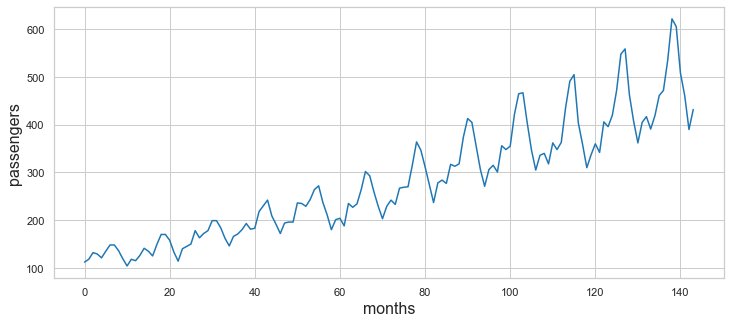

In [15]:
plt.figure(figsize=[12., 5.])
ax = sns.lineplot(data.index, data.passengers, data=data)
ax.set_xlabel('months');

In [16]:
# Convert passenter data to float32 for PyTorch
data.passengers = data.passengers.astype(np.float32)

# Reserve last 12 months as test set:
train_data = data.passengers[:-12].to_numpy().reshape(-1, 1)
valid_data = data.passengers[-12:].to_numpy().reshape(-1, 1)

# scale data
t_scaler = MinMaxScaler(feature_range=(-1, 1))
v_scaler = MinMaxScaler(feature_range=(-1, 1))
train_data = t_scaler.fit_transform(train_data)
valid_data = v_scaler.fit_transform(valid_data)

# convert training data to tensor
train_data = torch.tensor(train_data, dtype=torch.float32)
valid_data = torch.tensor(valid_data, dtype=torch.float32)

In [19]:

# Create validation set:
valid_x = valid_data[:-1]
valid_y = valid_data[1:]
valid_data = (valid_x, valid_y)

In [20]:
valid_datadd

(tensor([[-0.7672],
         [-0.9914],
         [-0.7500],
         [-0.3879],
         [-0.2931],
         [ 0.2500],
         [ 1.0000],
         [ 0.8621],
         [ 0.0172],
         [-0.3879],
         [-1.0000]]),
 tensor([[-0.9914],
         [-0.7500],
         [-0.3879],
         [-0.2931],
         [ 0.2500],
         [ 1.0000],
         [ 0.8621],
         [ 0.0172],
         [-0.3879],
         [-1.0000],
         [-0.6379]]))

In [21]:
def get_batches(data, window):
    """
    Takes data with shape (n_samples, n_features) and creates mini-batches
    with shape (1, window). 
    """

    L = len(data)
    for i in range(L - window):
        x_sequence = data[i:i + window]
        y_sequence = data[i+1: i + window + 1] 
        yield x_sequence, y_sequence

In [22]:

class flightLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        # Put your code here
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hs):
        # Put your code here
        # out.shape = (batch_size, seq_len, hidden_size)
        # out.shape = (seq_len, hidden_size)     
        
        lstm_out, hs = self.lstm(x, hs)
        lstm_out = lstm_out.view(-1, self.hidden_size)
        out = self.fc(lstm_out)
        
        return out, hs

In [26]:
input_size = 1
hidden_size = 100
num_layers = 1
output_size = 1

model = flightLSTM(input_size, hidden_size, num_layers, output_size)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [27]:
def train(model, epochs, train_set, valid_data=None, lr=0.001, print_every=100):

    criterion = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    
    train_loss = []
    valid_loss = []
    
    for e in range(epochs):
        
        hs = None
        t_loss = 0
        for x, y in get_batches(train_set, 12):

            opt.zero_grad()
            
            # Create batch_size dimension
            x = x.unsqueeze(0)
            out, hs = model(x, hs)
            hs = tuple([h.data for h in hs])
            
            loss = criterion(out, y)
            loss.backward()
            opt.step()
            t_loss += loss.item()
            
        if valid_data is not None:
                model.eval()
                val_x, val_y = valid_data
                val_x = val_x.unsqueeze(0)
                preds, _ = model(val_x, hs)
                v_loss = criterion(preds, val_y)
                valid_loss.append(v_loss.item())
                
                model.train()
            
        train_loss.append(np.mean(t_loss))
            
            
        if e % print_every == 0:
            print(f'Epoch {e}:\nTraining Loss: {train_loss[-1]}')
            if valid_data is not None:
                print(f'Validation Loss: {valid_loss[-1]}')
    
    plt.figure(figsize=[8., 6.])
    plt.plot(train_loss, label='Training Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.show()

Epoch 0:
Training Loss: 20.734133360907435
Validation Loss: 0.47042033076286316
Epoch 100:
Training Loss: 1.54987927316688
Validation Loss: 0.16884686052799225
Epoch 200:
Training Loss: 0.7638981911586598
Validation Loss: 0.1988733857870102
Epoch 300:
Training Loss: 0.7814215878024697
Validation Loss: 0.2941399812698364
Epoch 400:
Training Loss: 0.6048829790670425
Validation Loss: 0.25450313091278076


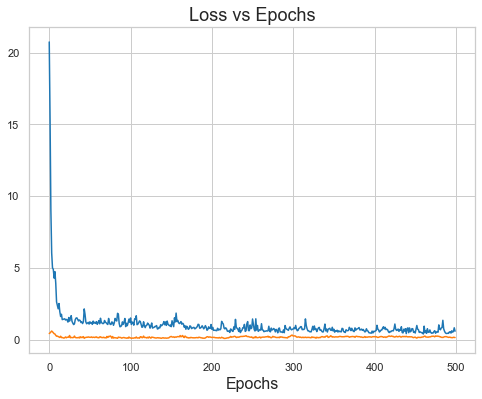

In [28]:
train(model, 500, train_data, lr=0.0005, valid_data=valid_data)

In [29]:
print(train_data.shape)
print(valid_x.shape)

torch.Size([132, 1])
torch.Size([11, 1])


In [30]:

# get predictions on training set
hs = None
train_preds, hs = model(train_data.unsqueeze(0), hs)
train_preds = t_scaler.inverse_transform(train_preds.detach())

# Get predictions on validation data
valid_preds, hs = model(valid_x.unsqueeze(0), hs)
valid_preds = v_scaler.inverse_transform(valid_preds.detach())

In [31]:
train_time = data.index[1:-11]
valid_time = data.index[-11:]

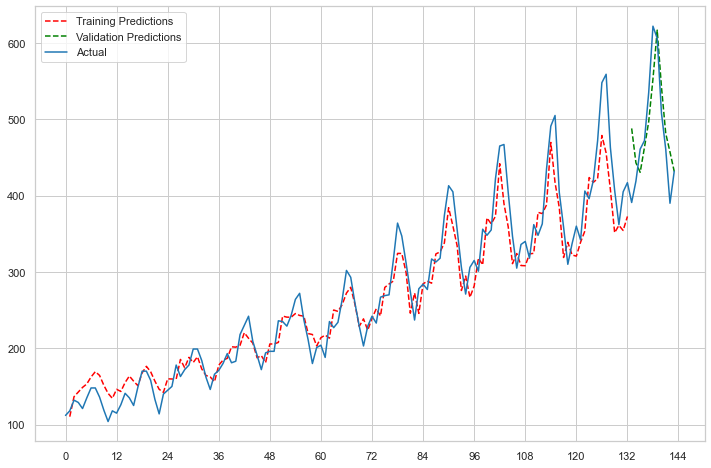

In [32]:
plt.plot(train_time, train_preds.squeeze(), 'r--', label='Training Predictions', )
plt.plot(valid_time, valid_preds.squeeze(), 'g--', label='Validation Predictions')
plt.plot(data.index, data.passengers.to_numpy(), label='Actual')
plt.xticks(np.arange(0,145,12))
plt.legend()